# Usage Library

In [108]:
import drms

from sunpy.time import TimeRange
from sunpy.instr.goes import get_goes_event_list

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

from IPython.display import display 
import pandas as pd 
from datetime import timedelta, date, datetime

# Create Solar Flare Events (Response Variables)

In [2]:
# Skip if already have the GOES list even
date_from = '2014/03/05 00:00'
date_to = '2014/03/06 23:59'

# Using SunPy to download the GOES flare list and save
time_range = TimeRange(date_from, date_to)
flare_events = pd.DataFrame.from_dict(get_goes_event_list(time_range))
flare_events.to_csv('goes_flare_list1.csv')

In [52]:
flare_events = pd.read_csv('goes_flare_list.csv')
flare_events.dropna(inplace = True)

In [53]:
flare_events.dtypes

start_time      object
end_time        object
peak_time       object
class           object
position        object
noaa_ar_num    float64
dtype: object

In [126]:
time_lag = 12 # in hours

In [142]:
class_mult = {'A':1e-8, 'B':1e-7, 'C':1e-6, 'M':1e-5, 'X': 1e-4}

def convert_class(c):
    cat, score = c[0], float(c[1:])
    
    return score * class_mult[cat]


flare_response = flare_events
flare_response['intensity'] = np.log(flare_events['class'].map(convert_class))
flare_response['peak_time'] = drms.to_datetime(flare_response['peak_time'])

flare_res = flare_response[['peak_time', 'noaa_ar_num', 'intensity']]
flare_res['ptim_lag_bf'] = flare_res['peak_time'].map(lambda t: t - timedelta(hours=time_lag))
flare_res.dropna(inplace=True)
flare_res.drop_duplicates(inplace=True)
flare_res = flare_res[flare_res['noaa_ar_num'] != 0]

/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/vietdo/opt/anaconda2/envs/mlpy36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [143]:
filter_df = datetime(2014, 3, 1)
filter_dt = datetime(2014, 8, 10)

flare_res= flare_res[(flare_res['peak_time'] >= filter_df) & (flare_res['peak_time'] <= filter_dt)]

In [144]:
flare_res.dropna(inplace=True)
display(flare_res.shape)

(383, 4)

## Solar flares from 2010/1/1 to 2015/12/31

In [113]:
xb = flare_res[(flare_res['intensity'] >= np.log(1e-7)) & (flare_res['intensity'] < np.log(1e-6))]['intensity']
xc = flare_res[(flare_res['intensity'] >= np.log(1e-6)) & (flare_res['intensity'] < np.log(1e-5))]['intensity']
xm = flare_res[(flare_res['intensity'] >= np.log(1e-5)) & (flare_res['intensity'] < np.log(1e-4))]['intensity']
xx = flare_res[(flare_res['intensity'] >= np.log(1e-4)) & (flare_res['intensity'] < np.log(1e-3))]['intensity']

## Histogram for flare intensity of all classes

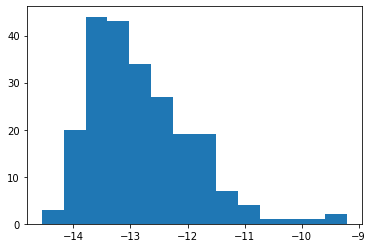

In [114]:
plt.hist(flare_res['intensity'], bins='auto') 
plt.show()

## Histogram for flare intensity class B

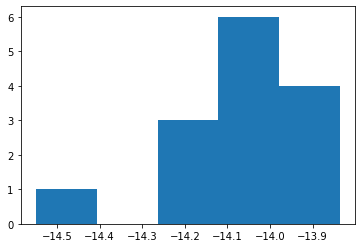

In [66]:
plt.hist(xb, bins='auto') 
plt.show()

## Histogram for flare intensity class C

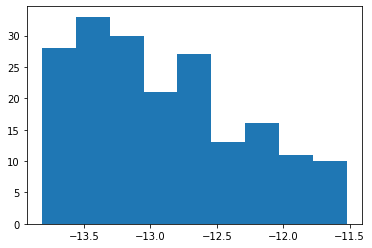

In [67]:
plt.hist(xc, bins='auto') 
plt.show()

## Histogram for flare intensity class M

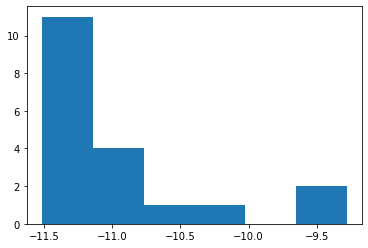

In [68]:
plt.hist(xm, bins='auto') 
plt.show()

## Histogram for flare intensity class X

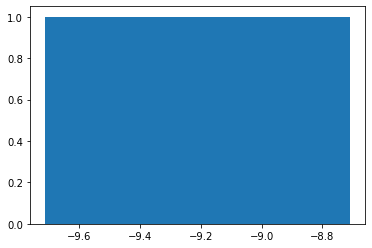

In [69]:
plt.hist(xx, bins='auto') 
plt.show()

# Download SHARP Covariate DataTable

## pull SHARP DRMS data from JSOC

In [70]:
# create a "client"
client = drms.Client()
# Check the data series which match the "sharp"
print(client.series(r'sharp_'))
serie = 'hmi.sharp_cea_720s' # this is what we need

['hmi.sharp_720s', 'hmi.sharp_720s_nrt', 'hmi.sharp_cea_720s', 'hmi.sharp_cea_720s_nrt', 'su_jeneen.sharp_720s', 'su_jeneen.sharp_cea_720s', 'su_mbobra.sharp_loskeys_720s']


In [134]:
flare_raw = client.query('hmi.sharp_cea_720s[][2014.06.15_00:00_TAI/60d@1h]',
    key=drms.const.all)

## create the local SHARP file with relevant covariates

In [135]:
flare_covariates = flare_raw[['T_REC','NOAA_AR','TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','ABSNJZH','TOTPOT', 'SIZE_ACR', 'NACR',
                             'MEANPOT', 'SIZE', 'MEANJZH', 'SHRGT45', 'MEANSHR', 'MEANJZD', 'MEANALP', 'MEANGBT',
                             'MEANGAM', 'MEANGBZ', 'MEANGBH']]
flare_covariates = flare_covariates.dropna()
flare_covariates['T_REC'] = drms.to_datetime(flare_covariates['T_REC'])

In [136]:
#flare_covariates.drop_duplicates(subset=['T_REC'], keep = 'first', inplace=True)
flare_covariates = flare_covariates[flare_covariates['NOAA_AR'] != 0]

In [137]:
pd.set_option('display.max_rows', 500)
display(flare_covariates.sort_values(['NOAA_AR','T_REC']).tail(500))

,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,ABSNJZH,TOTPOT,SIZE_ACR,NACR,...,SIZE,MEANJZH,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH
11074,2014-08-07 16:00:00,12128,613.138,1.211478e+13,6.610297e+11,1.322233e+22,14.237,5.414267e+22,172.826736,1912,...,2645.731445,-0.000732,6.364,20.754,-0.019693,-0.002162,84.154,26.731,89.101,34.347
11075,2014-08-07 17:00:00,12128,635.913,1.180878e+13,5.212314e+11,1.335321e+22,15.914,6.155001e+22,165.215347,1828,...,2545.925293,0.000841,5.662,20.307,-0.038793,0.002351,83.695,26.358,87.761,34.280
11076,2014-08-07 18:00:00,12128,685.300,1.261137e+13,3.174632e+11,1.449179e+22,17.920,6.649155e+22,164.387863,1819,...,2444.128418,0.000872,5.642,20.592,-0.010752,0.002444,83.151,26.271,87.134,34.188
11077,2014-08-07 19:00:00,12128,649.905,1.199174e+13,2.003269e+12,1.501266e+22,39.212,5.817636e+22,154.348160,1708,...,2338.989014,-0.001786,4.818,20.338,-0.015069,-0.005283,76.424,26.623,79.304,32.698
11078,2014-08-07 20:00:00,12128,610.614,1.103460e+13,2.862391e+12,1.412542e+22,49.416,5.481525e+22,145.671097,1612,...,2236.665771,-0.002413,4.678,19.699,-0.006287,-0.007096,77.678,26.334,81.329,33.097
11079,2014-08-07 21:00:00,12128,577.230,1.054797e+13,3.581742e+11,1.349834e+22,14.462,5.503396e+22,138.896698,1537,...,2134.418457,0.000755,4.634,19.556,0.034577,0.002127,79.544,26.093,83.503,33.842
11080,2014-08-07 22:00:00,12128,621.873,1.180111e+13,8.077672e+11,1.413012e+22,14.452,5.908752e+22,128.329544,1420,...,2032.306152,0.000709,5.194,20.260,-0.073278,0.002053,80.004,26.392,84.275,33.903
11081,2014-08-07 23:00:00,12128,642.536,1.305836e+13,1.826873e+12,1.450288e+22,19.763,6.485896e+22,117.042107,1295,...,1936.391602,0.000903,5.021,20.622,-0.006120,0.002830,82.138,26.267,90.686,34.194
11082,2014-08-08 00:00:00,12128,596.025,1.169867e+13,5.106002e+11,1.419092e+22,11.444,5.379135e+22,104.036980,1151,...,1846.453003,0.000534,4.096,19.489,-0.044101,0.001702,73.758,25.915,78.172,31.298
11083,2014-08-08 01:00:00,12128,563.599,1.068504e+13,2.311076e+11,1.387770e+22,17.114,4.328243e+22,91.574562,1013,...,1757.996582,-0.000814,3.072,18.470,0.019196,-0.002641,71.305,25.139,74.686,29.695


In [138]:
flare_covariates.to_csv('flares_covriates061560d.csv')

# Create solar flares dataset

In [161]:
flares_cov1 = pd.read_csv('flares_covriates021560d.csv').iloc[:,1:]
flares_cov2 = pd.read_csv('flares_covriates041660d.csv').iloc[:,1:]
flares_cov3 = pd.read_csv('flares_covriates061560d.csv').iloc[:,1:]

In [162]:
flares_cov = flares_cov1.append(flares_cov2, ignore_index= True).append(flares_cov3, ignore_index= True)
flares_cov.dropna(inplace=True)

In [165]:
flares_cov

,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,ABSNJZH,TOTPOT,SIZE_ACR,NACR,...,SIZE,MEANJZH,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH
0,2014-02-15 00:00:00,11973,216.199,5.122890e+12,2.242023e+12,6.452794e+21,23.961,1.555578e+22,137.358810,1602.0,...,2253.473145,-0.002156,0.504,18.416,-0.042560,-0.009445,77.711,23.080,77.683,26.925
1,2014-02-15 01:00:00,11973,211.770,4.959234e+12,2.288489e+12,6.256567e+21,24.706,1.461838e+22,127.860992,1491.0,...,2169.692139,-0.002300,0.391,18.103,-0.035040,-0.010076,78.533,23.131,78.569,27.365
2,2014-02-15 02:00:00,11973,210.364,5.020378e+12,2.633364e+12,6.357884e+21,27.204,1.456606e+22,115.874084,1351.0,...,2085.218750,-0.002465,0.807,18.150,-0.029788,-0.011029,77.719,22.997,78.200,26.955
3,2014-02-15 03:00:00,11973,210.487,4.981745e+12,2.881891e+12,6.443762e+21,30.843,1.383248e+22,116.577293,1359.0,...,1992.021973,-0.002755,0.456,17.835,-0.040115,-0.012381,74.338,22.848,74.740,25.314
4,2014-02-15 04:00:00,11973,216.836,5.074198e+12,2.323793e+12,6.464818e+21,28.308,1.389543e+22,116.594162,1359.0,...,1896.735596,-0.002560,0.651,17.968,-0.053582,-0.011208,75.217,22.972,75.520,26.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24637,2014-08-13 18:00:00,12134,287.902,5.458966e+12,1.138377e+12,6.993511e+21,11.569,2.859346e+22,110.400154,1224.0,...,1559.672852,-0.001157,2.050,20.956,-0.049916,-0.003292,81.861,26.493,82.277,33.035
24638,2014-08-13 19:00:00,12134,256.698,4.917313e+12,1.329100e+12,6.276984e+21,7.095,2.642949e+22,105.523979,1170.0,...,1447.752930,-0.000760,2.462,22.170,0.047665,-0.002264,80.833,27.616,81.014,32.621
24639,2014-08-13 21:00:00,12134,250.799,4.687219e+12,8.743158e+11,5.812442e+21,3.257,2.431119e+22,93.619095,1038.0,...,1336.822876,-0.000394,1.841,21.556,0.009682,-0.001092,83.209,27.011,83.320,35.060
24640,2014-08-13 22:00:00,12134,252.153,4.842855e+12,1.275145e+12,5.945721e+21,5.187,2.471622e+22,89.204559,989.0,...,1281.605347,-0.000610,1.930,21.836,-0.111968,-0.001711,82.923,27.217,82.584,35.596


In [166]:
flares_cov['T_REC'] = pd.to_datetime(flares_cov['T_REC'])

In [167]:
# Left Join flare_response with flare_covriates on noaa_active_region == NOAA_AR
flares_data = flare_res.merge(flares_cov, how = 'left', left_on = 'noaa_ar_num', right_on = 'NOAA_AR')
flares_data['abs_tim_diff'] = (flares_data['ptim_lag_bf'] -  flares_data['T_REC']).map(lambda d: abs(d.total_seconds()))
flares_data[['ptim_lag_bf', 'T_REC', 'abs_tim_diff']]

,ptim_lag_bf,T_REC,abs_tim_diff
0,2014-02-28 12:59:00,NaT,NaN
1,2014-03-01 04:00:00,2014-02-21 06:00:00,684000.0
2,2014-03-01 04:00:00,2014-02-21 07:00:00,680400.0
3,2014-03-01 04:00:00,2014-02-21 08:00:00,676800.0
4,2014-03-01 04:00:00,2014-02-21 09:00:00,673200.0
...,...,...,...
80495,2014-08-08 05:01:00,NaT,NaN
80496,2014-08-08 14:44:00,NaT,NaN
80497,2014-08-08 15:26:00,NaT,NaN
80498,2014-08-08 20:30:00,NaT,NaN


## Extract only SHARP parameters that are closest to pt_12h_bf

In [168]:
# add a min_tim_diff column which is the min time difference btw pt_12h_bf and T_REC group by Peak Time and Active Region
dfg = flares_data.groupby(['noaa_ar_num','peak_time'])['abs_tim_diff']
flares_data['min_tim_diff'] = dfg.transform(min)
# pick only the row with min(min_tim_diff)
flares = flares_data.loc[flares_data['min_tim_diff'] == flares_data['abs_tim_diff'] ]

In [169]:
flares

,peak_time,noaa_ar_num,intensity,ptim_lag_bf,T_REC,NOAA_AR,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,...,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGAM,MEANGBZ,MEANGBH,abs_tim_diff,min_tim_diff
181,2014-03-01 16:00:00,11987.0,-12.684108,2014-03-01 04:00:00,2014-03-01 04:00:00,11987.0,2810.555,5.792815e+13,1.254459e+13,3.343854e+22,...,19.263,31.115,0.460529,-0.018890,123.088,40.192,124.792,62.726,0.0,0.0
677,2014-03-02 00:12:00,11982.0,-11.652188,2014-03-01 12:12:00,2014-03-01 13:00:00,11982.0,667.322,1.350421e+13,1.916356e+12,1.998680e+22,...,11.628,22.571,-0.121556,-0.000991,66.111,29.428,75.715,28.667,2880.0,2880.0
835,2014-03-02 12:53:00,11990.0,-12.899220,2014-03-02 00:53:00,2014-03-02 01:00:00,11990.0,1536.948,3.155270e+13,1.907789e+13,1.623907e+22,...,34.422,38.058,0.552116,-0.044419,113.728,48.912,119.528,66.749,420.0,420.0
1193,2014-03-02 16:45:00,11987.0,-12.899220,2014-03-02 04:45:00,2014-03-02 05:00:00,11987.0,2624.521,5.496960e+13,8.037769e+12,3.362360e+22,...,17.391,29.927,0.294200,-0.014850,125.865,38.548,126.357,62.231,900.0,900.0
1631,2014-03-02 23:19:00,11986.0,-11.417615,2014-03-02 11:19:00,2014-03-02 11:00:00,11986.0,407.224,8.991812e+12,1.069138e+12,1.179462e+22,...,0.916,16.582,-0.015792,0.000410,78.243,21.511,79.787,26.956,1140.0,1140.0
1800,2014-03-04 04:55:00,11991.0,-11.699255,2014-03-03 16:55:00,2014-03-03 17:00:00,11991.0,1680.628,3.475920e+13,1.437470e+13,1.739169e+22,...,51.110,47.498,0.185025,-0.027421,101.570,57.413,103.688,70.310,300.0,300.0
2103,2014-03-04 08:32:00,11991.0,-12.822259,2014-03-03 20:32:00,2014-03-03 21:00:00,11991.0,1752.971,3.617429e+13,1.691545e+13,1.767197e+22,...,48.455,46.179,0.094600,-0.029948,105.787,56.345,108.987,72.357,1680.0,1680.0
2414,2014-03-05 00:16:00,11991.0,-12.246895,2014-03-04 12:16:00,2014-03-04 12:00:00,11991.0,1682.902,3.322242e+13,2.334713e+13,1.612842e+22,...,42.384,42.913,0.353095,-0.048167,113.116,53.725,114.309,73.461,960.0,960.0
2715,2014-03-05 01:58:00,11991.0,-12.785891,2014-03-04 13:58:00,2014-03-04 14:00:00,11991.0,1697.524,3.238030e+13,2.224982e+13,1.619710e+22,...,41.103,42.127,0.259256,-0.045619,115.056,53.296,117.766,74.031,120.0,120.0
2945,2014-03-05 17:40:00,11996.0,-13.345507,2014-03-05 05:40:00,2014-03-05 06:00:00,11996.0,894.628,1.852533e+13,4.037279e+12,9.583304e+21,...,22.118,33.021,-0.081727,-0.020905,130.736,40.176,134.362,65.306,1200.0,1200.0


## Create final solar flares dataset

In [170]:
X_flares = flares[['TOTUSJH','TOTUSJZ','SAVNCPP','USFLUX','ABSNJZH','TOTPOT', 'SIZE_ACR', 'NACR',
                             'MEANPOT', 'SIZE', 'MEANJZH', 'SHRGT45', 'MEANSHR', 'MEANJZD', 'MEANALP', 'MEANGBT',
                             'MEANGAM', 'MEANGBZ', 'MEANGBH']]
y_flares = flares[['intensity']]

In [ ]:
X_flares.to_csv()